##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 1 - Prompting

Welcome to the Kaggle 5-day Generative AI course!

This notebook will show you how to get started with the Gemini API and walk you through some of the example prompts and techniques that you can also read about in the Prompting whitepaper. You don't need to read the whitepaper to use this notebook, but the papers will give you some theoretical context and background to complement this interactive notebook.


## Before you begin

In this notebook, you'll start exploring prompting using the Python SDK and AI Studio. For some inspiration, you might enjoy exploring some apps that have been built using the Gemini family of models. Here are a few that we like, and we think you will too.

* [TextFX](https://textfx.withgoogle.com/) is a suite of AI-powered tools for rappers, made in collaboration with Lupe Fiasco,
* [SQL Talk](https://sql-talk-r5gdynozbq-uc.a.run.app/) shows how you can talk directly to a database using the Gemini API,
* [NotebookLM](https://notebooklm.google/) uses Gemini models to build your own personal AI research assistant.


## For help

**Common issues are covered in the [FAQ and troubleshooting guide](https://www.kaggle.com/code/markishere/day-0-troubleshooting-and-faqs).**

## New for Gemini 2.0!

This course material was first launched in November 2024. The AI and LLM space is moving incredibly fast, so we have made some updates to use the latest models and capabilities.

* These codelabs have been updated to use the Gemini 2.0 family of models.
* The Python SDK has been updated from `google-generativeai` to the new, unified [`google-genai`](https://pypi.org/project/google-genai) SDK.
  * This new SDK works with both the developer Gemini API as well as Google Cloud Vertex AI, and switching is [as simple as changing some fields](https://pypi.org/project/google-genai/#:~:text=.Client%28%29-,API%20Selection,-By%20default%2C%20the).
* New model capabilities have been added to the relevant codelabs, such as "thinking mode" in this lab.
* Day 1 includes a new [Evaluation codelab](https://www.kaggle.com/code/markishere/day-1-evaluation-and-structured-output).

## Get started with Kaggle notebooks

If this is your first time using a Kaggle notebook, welcome! You can read about how to use Kaggle notebooks [in the docs](https://www.kaggle.com/docs/notebooks).

First, you will need to phone verify your account at kaggle.com/settings.

![](https://storage.googleapis.com/kaggle-media/Images/5dgai_0.png)
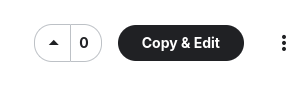
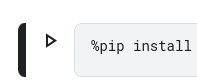

To run this notebook, as well as the others in this course, you will need to make a copy, or fork, the notebook. Look for the `Copy and Edit` button in the top-right, and **click it** to make an editable, private copy of the notebook. It should look like this one:

![Copy and Edit button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_1.png)

Your copy will now have a ▶️ **Run** button next to each code cell that you can press to execute that cell. These notebooks are expected to be run in order from top-to-bottom, but you are encouraged to add new cells, run your own code and explore. If you get stuck, you can try the `Factory reset` option in the `Run` menu, or head back to the original notebook and make a fresh copy.

![Run cell button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_2.png)

### Problems?

If you have any problems, head over to the [Kaggle Discord](https://discord.com/invite/kaggle), find the [`#5dgai-q-and-a` channel](https://discord.com/channels/1101210829807956100/1303438695143178251) and ask for help.

## Get started with the Gemini API

All of the exercises in this notebook will use the [Gemini API](https://ai.google.dev/gemini-api/) by way of the [Python SDK](https://pypi.org/project/google-genai/). Each of these prompts can be accessed directly in [Google AI Studio](https://aistudio.google.com/) too, so if you would rather use a web interface and skip the code for this activity, look for the <img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> AI Studio link on each prompt.

Next, you will need to add your API key to your Kaggle Notebook as a Kaggle User Secret.

![](https://storage.googleapis.com/kaggle-media/Images/5dgai_1.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_2.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_3.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_4.png)

### Install the SDK

In [2]:
!pip uninstall -qqy jupyterlab  # Remove unused packages from Kaggle's base image that conflict
!pip install -U -q "google-genai==1.7.0"

Import the SDK and some helpers for rendering the output.

In [3]:
from google import genai
from google.genai import types

from IPython.display import HTML, Markdown, display

Set up a retry helper. This allows you to "Run all" without worrying about per-minute quota.

In [4]:
from google.api_core import retry


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [5]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)
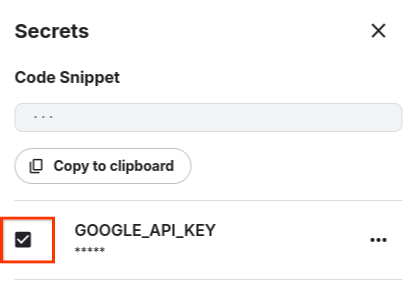

### Run your first prompt

In this step, you will test that your API key is set up correctly by making a request.

The Python SDK uses a [`Client` object](https://googleapis.github.io/python-genai/genai.html#genai.client.Client) to make requests to the API. The client lets you control which back-end to use (between the Gemini API and Vertex AI) and handles authentication (the API key).

The `gemini-2.0-flash` model has been selected here.

**Note**: If you see a `TransportError` on this step, you may need to **🔁 Factory reset** the notebook one time.

In [6]:
client = genai.Client(api_key=GOOGLE_API_KEY)

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents="Explain the steps to implement Rag technique.")

print(response.text)

The Retrieval-Augmented Generation (RAG) technique combines the strengths of retrieval-based and generation-based approaches for natural language processing. It allows language models to access and incorporate external knowledge sources, leading to more accurate, informative, and contextually relevant responses. Here's a breakdown of the steps involved in implementing RAG:

**1. Data Preparation and Indexing:**

*   **Gather Data:**
    *   **Identify Relevant Knowledge Sources:** Determine the knowledge domains relevant to your application (e.g., documentation, knowledge bases, web pages, research papers).
    *   **Extract Data:**  Extract the information from these sources. This might involve:
        *   Web scraping for online content.
        *   Reading files (PDFs, TXT, DOCX, etc.).
        *   Querying databases.
        *   Using APIs to access structured data.

*   **Chunking:**
    *   **Divide Data into Manageable Chunks:** Break down the extracted data into smaller, meani

In [7]:
response2=client.models.generate_content(
    model="gemini-2.0-flash",
    contents="Is the responses of the chatbot should be stored in DB and which data should be stored?")
print(response2.text)

Yes, storing chatbot responses and related data in a database is generally a good practice for several reasons. It allows you to:

*   **Improve the chatbot:** Analyze user interactions to identify areas where the chatbot struggles, refine its responses, and train it on new data.
*   **Personalize the user experience:** Store user preferences and conversation history to provide more relevant and personalized responses.
*   **Track performance:** Monitor key metrics like user engagement, conversation length, and task completion rates to assess the chatbot's effectiveness.
*   **Ensure compliance:** Maintain a record of user interactions to comply with data privacy regulations and legal requirements.
*   **Troubleshoot issues:** Investigate and resolve technical problems by examining conversation logs and error messages.
*   **Generate reports:** Create reports on chatbot usage patterns, user feedback, and other relevant metrics.

Here's a breakdown of the data you should consider storin

The response often comes back in markdown format, which you can render directly in this notebook.

In [8]:
Markdown(response.text)

The Retrieval-Augmented Generation (RAG) technique combines the strengths of retrieval-based and generation-based approaches for natural language processing. It allows language models to access and incorporate external knowledge sources, leading to more accurate, informative, and contextually relevant responses. Here's a breakdown of the steps involved in implementing RAG:

**1. Data Preparation and Indexing:**

*   **Gather Data:**
    *   **Identify Relevant Knowledge Sources:** Determine the knowledge domains relevant to your application (e.g., documentation, knowledge bases, web pages, research papers).
    *   **Extract Data:**  Extract the information from these sources. This might involve:
        *   Web scraping for online content.
        *   Reading files (PDFs, TXT, DOCX, etc.).
        *   Querying databases.
        *   Using APIs to access structured data.

*   **Chunking:**
    *   **Divide Data into Manageable Chunks:** Break down the extracted data into smaller, meaningful segments.  Careful chunking is *crucial* for retrieval performance.  Consider these factors:
        *   **Chunk Size:** Smaller chunks capture more granular details but can lose context. Larger chunks retain context but may retrieve irrelevant information.  Experiment to find the optimal size for your data and use case.  Common sizes are around 100-500 tokens.
        *   **Chunking Strategies:**
            *   **Fixed-Size Chunking:** Simple, but may split sentences or paragraphs awkwardly.
            *   **Semantic Chunking:** Uses sentence segmentation or other NLP techniques to ensure chunks are semantically coherent.
            *   **Recursive Chunking:** Divides text recursively based on headings, paragraphs, and sentences. This is often a very good strategy for retaining hierarchies.
            *   **Overlapping Chunks:** Include some overlap between chunks to maintain continuity, especially when using smaller chunks.

*   **Embeddings:**
    *   **Create Vector Embeddings:**  Convert each chunk into a vector representation using a suitable embedding model (e.g., Sentence Transformers, OpenAI's `text-embedding-ada-002`, or other pre-trained or fine-tuned models).  The embedding model should be chosen based on the characteristics of your data and the type of queries you expect.
    *   **Embedding Quality:** The quality of your embeddings directly impacts retrieval accuracy.  Choose a model trained on data similar to your knowledge base and consider fine-tuning it.

*   **Indexing:**
    *   **Store Embeddings in a Vector Database (Vector Store):**  Use a vector database to efficiently store and index the generated embeddings.  Popular options include:
        *   **Pinecone:** Scalable and performant cloud-based vector database.
        *   **Weaviate:** Open-source vector search engine with graph capabilities.
        *   **ChromaDB:** Open-source embedding database.
        *   **FAISS (Facebook AI Similarity Search):**  Library for efficient similarity search and clustering of dense vectors.
        *   **Milvus:** Open-source vector database built for AI applications.
    *   **Populate the Vector Database:** Load the embeddings and corresponding text chunks into the vector database. Configure the database for efficient similarity search.

**2. Query and Retrieval:**

*   **Formulate Query:**  The user inputs a question or query.

*   **Embed Query:** Convert the user's query into a vector embedding using the *same embedding model* used to embed the data chunks.  This consistency is vital for accurate similarity search.

*   **Similarity Search:**  Perform a similarity search in the vector database to find the chunks whose embeddings are most similar to the query embedding. The vector database uses similarity metrics like cosine similarity or dot product to identify the top `k` most relevant chunks.

*   **Retrieve Relevant Chunks:**  Retrieve the top `k` chunks of text and their corresponding metadata (e.g., source document, title) from the vector database.  The value of `k` is a hyperparameter that you can tune. A higher `k` might retrieve more relevant information but can also introduce irrelevant information.

**3. Generation:**

*   **Context Augmentation:** Combine the retrieved chunks with the original query to create a context-augmented prompt.  This is the *core* of the RAG process.  The goal is to provide the language model with the relevant knowledge it needs to generate a high-quality response. Common approaches include:
    *   **Simple Concatenation:**  Simply concatenate the retrieved chunks with the query.
    *   **Prompt Engineering:** Craft a more sophisticated prompt that explicitly instructs the language model to use the retrieved information to answer the query.  For example:
        *   "Answer the following question based on the context provided. Question: {query} Context: {retrieved_chunks}"
        *   "Use the following information to answer the question: {query}. Information: {retrieved_chunks}"

*   **Generate Response:**  Feed the context-augmented prompt to a large language model (LLM) like GPT-3.5, GPT-4, Llama 2, PaLM 2, or others.  The LLM uses its pre-trained knowledge and the provided context to generate a response to the query.

*   **Response Refinement (Optional):**  Optionally, refine the generated response using techniques like:
    *   **Post-processing:** Correct grammar, spelling, and punctuation errors.
    *   **Filtering:**  Remove irrelevant or redundant information.
    *   **Summarization:** Condense the response for brevity.

**4. Evaluation and Iteration:**

*   **Evaluate Performance:**  Evaluate the quality of the RAG system's responses using metrics such as:
    *   **Relevance:** How well the response addresses the query.
    *   **Accuracy:** How factually correct the response is.
    *   **Coherence:** How well the response is written and organized.
    *   **Groundedness:** How well the response is supported by the retrieved context.
    *   **Hallucination:** Assessing if the LLM is making up facts.

*   **Iterate and Refine:** Based on the evaluation results, iterate on the following aspects of the RAG system:
    *   **Chunking Strategy:** Adjust chunk size and chunking method.
    *   **Embedding Model:** Experiment with different embedding models or fine-tune the existing model.
    *   **Vector Database:** Explore different vector databases and indexing techniques.
    *   **Retrieval Strategy:** Adjust the value of `k` (number of retrieved chunks).
    *   **Prompt Engineering:** Refine the prompt to better guide the LLM.
    *   **LLM:** Experiment with different LLMs or fine-tune the chosen LLM.

**Key Considerations and Best Practices:**

*   **Prompt Engineering is Critical:**  The prompt is the interface between the retrieved context and the language model. Well-crafted prompts can significantly improve the quality of the generated responses.
*   **Context Window Limits:**  Language models have a limited context window (the amount of text they can process at once).  Ensure that the combined length of the query and retrieved chunks does not exceed the LLM's context window.  Consider techniques like truncation or summarization if necessary.
*   **Data Quality Matters:**  The quality of the data used to build the knowledge base directly impacts the performance of the RAG system.  Clean and accurate data is essential.
*   **Trade-offs Between Retrieval and Generation:**  RAG balances the benefits of retrieval and generation.  Retrieval provides factual grounding, while generation provides fluency and expressiveness.  Finding the right balance is crucial for achieving optimal performance.
*   **Metadata Management:** Include relevant metadata (source document, timestamps, etc.) with each chunk. This metadata can be used for filtering and improving the retrieval process.
*   **Hybrid Retrieval Methods:** Consider combining vector search with other retrieval methods, such as keyword search or semantic search, to improve accuracy.
*   **Continuous Monitoring:** Continuously monitor the performance of the RAG system and retrain or update the knowledge base as needed.
*   **Experimentation is Key:** RAG is a highly adaptable technique. Don't be afraid to experiment with different approaches to find the best configuration for your specific use case.
*   **Security:** Be aware of potential security vulnerabilities, such as prompt injection attacks, and implement appropriate security measures. Validate and sanitize user inputs and consider implementing guardrails to prevent the LLM from generating harmful or inappropriate content.

By following these steps and continuously refining your approach, you can build a powerful and effective RAG system that leverages external knowledge to generate high-quality responses. Remember that the optimal configuration will depend on your specific data, use case, and the capabilities of the chosen LLM.


In [9]:
Markdown(response2.text)

Yes, storing chatbot responses and related data in a database is generally a good practice for several reasons. It allows you to:

*   **Improve the chatbot:** Analyze user interactions to identify areas where the chatbot struggles, refine its responses, and train it on new data.
*   **Personalize the user experience:** Store user preferences and conversation history to provide more relevant and personalized responses.
*   **Track performance:** Monitor key metrics like user engagement, conversation length, and task completion rates to assess the chatbot's effectiveness.
*   **Ensure compliance:** Maintain a record of user interactions to comply with data privacy regulations and legal requirements.
*   **Troubleshoot issues:** Investigate and resolve technical problems by examining conversation logs and error messages.
*   **Generate reports:** Create reports on chatbot usage patterns, user feedback, and other relevant metrics.

Here's a breakdown of the data you should consider storing in the database:

**1. User Information:**

*   **User ID:** A unique identifier for each user (if available, can be an internal user ID or a hashed representation of their email/phone number).
*   **Demographic data:** (Optional, but useful for segmentation) Age, gender, location, language, etc.  **Important:** Be mindful of privacy regulations and only collect data that is necessary and with user consent.
*   **Registration date/time:** When the user first interacted with the chatbot.

**2. Conversation Data:**

*   **Conversation ID:** A unique identifier for each conversation session.
*   **Timestamp:** The date and time of each message.
*   **User Input:** The exact text or data the user sent to the chatbot.
*   **Chatbot Response:** The text or data the chatbot sent to the user.
*   **Intent:** The identified intent of the user's message (e.g., "book_flight", "check_weather"). This requires intent recognition to be built into your chatbot.
*   **Entities:** The specific data extracted from the user's message (e.g., "New York" as the destination, "tomorrow" as the date).  Requires entity recognition.
*   **Confidence Score:** The confidence level of the intent and entity recognition.  This is very helpful for identifying uncertain or ambiguous user input.
*   **Context:** The current state of the conversation (e.g., which question the chatbot is currently asking, which step the user is on in a multi-step process).  Critical for maintaining context across multiple turns.
*   **Feedback:**  User feedback on the chatbot's responses (e.g., thumbs up/down, rating, or a free-text comment). This is vital for improving chatbot performance.
*   **Channel:** The platform used for the conversation (e.g., web chat, Facebook Messenger, Slack).
*   **Error Messages:** Any error messages encountered during the conversation.
*   **API Calls & Results:** If the chatbot interacts with external APIs, store the API requests and responses.
*   **Assigned Agent (if applicable):** If a human agent takes over the conversation, record the agent's ID.
*   **Conversation Resolution:**  How the conversation ended (e.g., "successfully completed task," "user abandoned," "transferred to agent").
*   **User satisfaction:** A metric indicating the user's satisfaction with the conversation (e.g., a rating scale, sentiment analysis of their messages).

**3. Chatbot Performance Data:**

*   **Conversation Length:** The number of messages exchanged in a conversation.
*   **Conversation Duration:** The total time of the conversation.
*   **Task Completion Rate:** The percentage of conversations that successfully complete a desired task.
*   **Fallback Rate:** The percentage of times the chatbot fails to understand the user's intent and resorts to a fallback response.  High fallback rates indicate areas for improvement.
*   **Containment Rate:** The percentage of conversations that are resolved without human intervention.

**Database Considerations:**

*   **Database Type:** Choose a database that is suitable for storing large volumes of text data and supporting complex queries.  Popular options include:
    *   **Relational Databases (SQL):** PostgreSQL, MySQL.  Good for structured data and complex queries.
    *   **NoSQL Databases:** MongoDB (document database), Cassandra (column family database).  Good for unstructured data and scalability.
*   **Data Modeling:** Design the database schema carefully to ensure data integrity and efficient querying.
*   **Indexing:** Use indexes to speed up queries.
*   **Data Security:** Implement appropriate security measures to protect sensitive user data.
*   **Data Retention Policy:** Define a policy for how long data will be stored. Comply with privacy regulations.

**Example Table Structure (Simplified, using PostgreSQL):**

```sql
-- Users Table
CREATE TABLE users (
    user_id SERIAL PRIMARY KEY,
    username VARCHAR(255),
    -- other user information
    created_at TIMESTAMP DEFAULT NOW()
);

-- Conversations Table
CREATE TABLE conversations (
    conversation_id UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    user_id INTEGER REFERENCES users(user_id),
    start_time TIMESTAMP DEFAULT NOW(),
    end_time TIMESTAMP,
    resolution VARCHAR(255)
);

-- Messages Table
CREATE TABLE messages (
    message_id UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    conversation_id UUID REFERENCES conversations(conversation_id),
    sender VARCHAR(50) CHECK (sender IN ('user', 'bot')),
    message_text TEXT,
    intent VARCHAR(255),
    entities JSONB,
    timestamp TIMESTAMP DEFAULT NOW()
);

-- Feedback Table
CREATE TABLE feedback (
    feedback_id SERIAL PRIMARY KEY,
    conversation_id UUID REFERENCES conversations(conversation_id),
    user_rating INTEGER,
    comment TEXT,
    timestamp TIMESTAMP DEFAULT NOW()
);
```

**Important Considerations for GDPR and Privacy:**

*   **Data Minimization:** Only collect data that is strictly necessary for the purposes you have defined.
*   **User Consent:** Obtain explicit consent from users before collecting and storing their personal data.  This is especially important for demographic information.
*   **Transparency:** Be transparent about how you are collecting and using user data.  Provide a clear privacy policy.
*   **Right to Access:** Provide users with the ability to access and correct their personal data.
*   **Right to Erasure (Right to be Forgotten):** Allow users to request that their personal data be deleted.
*   **Data Security:** Implement strong security measures to protect user data from unauthorized access or disclosure.
*   **Anonymization/Pseudonymization:** Consider anonymizing or pseudonymizing data to reduce the risk of re-identification.

By carefully considering these factors, you can design a database that effectively stores chatbot data, enabling you to improve the chatbot's performance, personalize the user experience, and ensure compliance with data privacy regulations. Remember to prioritize user privacy and be transparent about your data collection practices.


### Start a chat

The previous example uses a single-turn, text-in/text-out structure, but you can also set up a multi-turn chat structure too.

In [10]:
chat = client.chats.create(model='gemini-2.0-flash', history=[])
response = chat.send_message('Hello! My name is Zlork.')
print(response.text)

Greetings, Zlork! It's nice to meet you. How can I help you today?



In [11]:
response = chat.send_message('Can you tell me something interesting about dinosaurs?')
print(response.text)

Okay, here's an interesting fact about dinosaurs:

**Many dinosaurs likely had feathers, even some of the largest and most fearsome ones!**

While we often picture dinosaurs as scaly reptiles, evidence suggests that feathers were much more widespread than initially thought. This isn't just about small, bird-like dinosaurs; even some theropods (the group that includes *Tyrannosaurus rex*) may have had some feathery coverings, especially when they were younger. These weren't necessarily for flight, but could have served purposes like insulation, display, or camouflage.

This discovery has significantly changed our understanding of dinosaur evolution and their connection to birds. It also adds a fascinating level of detail to our mental image of these magnificent creatures!



While you have the `chat` object alive, the conversation state
persists. Confirm that by asking if it knows the user's name.

In [12]:
response = chat.send_message('How i can integrate a chatbot consist a bert model and Rag technique')
Markdown(response.text)

Okay, integrating a chatbot that uses a BERT model and Retrieval-Augmented Generation (RAG) is a complex but rewarding task. Here's a breakdown of the key steps and considerations involved:

**1. Data Preparation & Indexing (for RAG)**

*   **Data Collection:** Gather the knowledge base you want your chatbot to access. This could be documents, articles, FAQs, code snippets, or any other relevant text data.
*   **Data Cleaning & Preprocessing:** Clean the data to remove irrelevant information (e.g., HTML tags, special characters). You might also need to split large documents into smaller chunks to improve retrieval accuracy. Techniques include sentence splitting or fixed-size chunking.
*   **Embedding Generation:** Use BERT (or a similar transformer model) to create embeddings (vector representations) of your text chunks. These embeddings capture the semantic meaning of the text.  You can use a pre-trained BERT model (e.g., `bert-base-uncased`, `sentence-transformers/all-mpnet-base-v2` for better sentence embeddings) or fine-tune one on your specific data if you have enough training examples.
*   **Index Creation:** Store the embeddings and their corresponding text chunks in a vector database (also called a vector store).  Popular options include:
    *   **FAISS:**  Fast and efficient, especially for large datasets.  Good for local development and deployment.
    *   **Annoy:**  Another fast library for approximate nearest neighbor search.
    *   **Pinecone:**  A managed vector database service.  Scalable and easy to integrate.
    *   **Weaviate:**  An open-source vector database with a GraphQL interface.
    *   **ChromaDB:** Another popular open source vector database.
    *   **Milvus:**  Another open-source vector database built for AI applications.

**2. Chatbot Implementation**

*   **User Input Processing:**
    *   **Text Input:**  Receive the user's query as text.
    *   **Embedding Generation (Query):**  Use the same BERT model you used for your knowledge base to create an embedding of the user's query. This ensures compatibility when searching the vector database.
*   **Retrieval:**
    *   **Similarity Search:**  Use the query embedding to perform a similarity search in your vector database.  This retrieves the *k* most relevant text chunks from your knowledge base (where *k* is a hyperparameter you can tune). Common similarity metrics include cosine similarity and dot product.
*   **Augmentation (RAG):**
    *   **Contextualization:** Combine the retrieved text chunks with the user's query.  This creates a context-rich input for the BERT model.  You can do this by:
        *   **Concatenation:** Simply concatenate the query and the retrieved documents (with separators like `[SEP]` or `\n\n`).
        *   **Prompt Engineering:**  Create a prompt that instructs BERT to answer the query based on the provided context. For example:  `"Answer the following question based on the context provided. Question: {query} Context: {retrieved_text}"`.  Good prompt engineering is *crucial* for RAG performance.
*   **Generation:**
    *   **Pass to BERT:** Feed the combined (query + context) input to a BERT model.  Crucially, you need to use a *generative* BERT model (or a model fine-tuned for text generation) to produce the chatbot's response. Options include:
        *   **BERT2BERT:** An encoder-decoder model where both the encoder and decoder are based on BERT.
        *   **BART (Bidirectional and Auto-Regressive Transformer):**  Good for sequence-to-sequence tasks like text generation.
        *   **T5 (Text-to-Text Transfer Transformer):**  Trained on a massive dataset and can perform a wide range of text-based tasks.
        *   **GPT-2/GPT-3/GPT-4 (via API):** While not strictly BERT, these models can be integrated into a RAG pipeline for powerful generation.  Consider the cost implications of using these APIs.
    *   **Response Decoding:** Decode the output of the BERT model to generate the chatbot's text response.
*   **Response Formatting:**
    *   Format the response for readability.  You might want to add line breaks, bullet points, or other formatting elements.

**3. Frameworks and Libraries**

Several frameworks can simplify the development process:

*   **LangChain:**  A powerful framework specifically designed for building applications with language models. It provides modules for data loading, text splitting, vector store integration, prompt engineering, and language model orchestration.  Highly recommended.
*   **LlamaIndex:** Another framework like Langchain for integrating your data with LLMs.
*   **Transformers (Hugging Face):** Essential for working with BERT and other transformer models. Provides pre-trained models, tokenizers, and utilities for fine-tuning.
*   **Haystack:** An open-source framework for building search systems, including question answering systems.
*   **Sentence Transformers:** A library specifically designed for generating high-quality sentence embeddings.

**4. Code Example (Conceptual - using LangChain)**

```python
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFaceHub  # Or OpenAI, etc.
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader

# 1. Load and prepare your data
loader = TextLoader("my_knowledge_base.txt") # Replace with your data loading
documents = loader.load()

# 2. Create embeddings
embeddings = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2") # Choose a good sentence embedding model

# 3. Create a vector store
db = FAISS.from_documents(documents, embeddings)

# 4. Initialize the language model (Choose a generative model)
llm = HuggingFaceHub(repo_id="google/flan-t5-xxl", model_kwargs={"temperature":0.5, "max_length":512}) # Example with FLAN-T5

# 5. Create a RetrievalQA chain (RAG)
qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=db.as_retriever(search_kwargs={"k": 3})) # 'stuff' is a simple chain type

# 6. Chatbot loop
while True:
    query = input("Ask me anything: ")
    if query.lower() == "exit":
        break
    result = qa({"query": query})
    print(result["result"])
```

**Explanation of the code:**

*   **Data Loading:**  Loads your knowledge base (replace `"my_knowledge_base.txt"` with your actual data).
*   **Embeddings:**  Creates sentence embeddings using `HuggingFaceEmbeddings`.
*   **Vector Store:**  Indexes the embeddings in a FAISS vector store.
*   **Language Model:**  Initializes a language model (in this case, FLAN-T5 hosted on Hugging Face Hub).  You'll need an API key for Hugging Face Hub.  You can also use OpenAI, but that requires a paid OpenAI API key.
*   **RetrievalQA Chain:**  Creates a `RetrievalQA` chain that combines retrieval (from the vector store) and generation (with the language model). The `chain_type="stuff"` argument specifies a simple way of combining the retrieved documents into the prompt.  `search_kwargs={"k": 3}` specifies the number of documents to retrieve.
*   **Chatbot Loop:**  Gets user input, runs the query through the `RetrievalQA` chain, and prints the result.

**5. Key Considerations and Challenges**

*   **Computational Resources:** Training and running large BERT models can be computationally expensive. Consider using a GPU or cloud-based resources.
*   **Fine-Tuning:** Fine-tuning the BERT model on your specific dataset can significantly improve performance, but requires a substantial amount of labeled data.
*   **Context Length:**  BERT has a limited context length (e.g., 512 tokens).  Carefully consider how you split your documents and create your prompts to stay within this limit.  Longer context models exist, like Longformer or even newer models that extend beyond typical BERT models.
*   **Hallucinations:**  Language models can sometimes generate incorrect or nonsensical answers (hallucinations). RAG can help reduce this by providing the model with grounded context.
*   **Prompt Engineering:** Designing effective prompts is crucial for getting good results with RAG. Experiment with different prompts to find what works best for your task.
*   **Scalability:**  For production deployments, you'll need to consider scalability.  Vector databases like Pinecone and Weaviate are designed to handle large datasets and high query volumes.
*   **Evaluation:**  Thoroughly evaluate your chatbot's performance to identify areas for improvement.  Metrics like accuracy, relevance, and fluency are important.
*   **Cost:**  Consider the cost of using cloud-based services like OpenAI, Pinecone, or Hugging Face Hub.

**In summary, building a BERT-powered chatbot with RAG involves data preparation, embedding generation, vector database indexing, chatbot implementation, and careful consideration of performance and scalability. Using frameworks like LangChain and Hugging Face Transformers can greatly simplify the development process.** Good luck!


### Choose a model

The Gemini API provides access to a number of models from the Gemini model family. Read about the available models and their capabilities on the [model overview page](https://ai.google.dev/gemini-api/docs/models/gemini).

In this step you'll use the API to list all of the available models.

In [13]:
for model in client.models.list():
  print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01

The [`models.list`](https://ai.google.dev/api/models#method:-models.list) response also returns additional information about the model's capabilities, like the token limits and supported parameters.

In [14]:
from pprint import pprint

for model in client.models.list():
  if model.name == 'models/gemini-2.0-flash':
    pprint(model.to_json_dict())
    break

{'description': 'Gemini 2.0 Flash',
 'display_name': 'Gemini 2.0 Flash',
 'input_token_limit': 1048576,
 'name': 'models/gemini-2.0-flash',
 'output_token_limit': 8192,
 'supported_actions': ['generateContent', 'countTokens'],
 'tuned_model_info': {},
 'version': '2.0'}


## Explore generation parameters



### Output length

When generating text with an LLM, the output length affects cost and performance. Generating more tokens increases computation, leading to higher energy consumption, latency, and cost.

To stop the model from generating tokens past a limit, you can specify the `max_output_tokens` parameter when using the Gemini API. Specifying this parameter does not influence the generation of the output tokens, so the output will not become more stylistically or textually succinct, but it will stop generating tokens once the specified length is reached. Prompt engineering may be required to generate a more complete output for your given limit.

In [15]:
from google.genai import types

short_config = types.GenerateContentConfig(max_output_tokens=200)

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='Write a 1000 word essay on the importance of olives in modern society.')

print(response.text)

## The Olive's Enduring Embrace: Importance in Modern Society

The olive, a humble fruit borne from the ancient Olea europaea, transcends its status as a simple ingredient. Its influence ripples through history, culture, and the modern world, impacting culinary landscapes, health paradigms, economic sectors, and even environmental consciousness. From the verdant groves of the Mediterranean to the sophisticated palates of global consumers, the olive maintains an enduring embrace on society, underscoring its vital importance in a multitude of ways.

Firstly, the olive's impact on culinary traditions and contemporary cuisine is undeniable. For millennia, olives have been a cornerstone of Mediterranean gastronomy, a region recognized for its healthy and delicious diet. Eaten whole, brined, or pressed into oil, olives contribute unique flavors and textures to a vast array of dishes. Their inherent bitterness, tempered by curing processes, adds a depth and complexity that elevates simple far

In [16]:
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='Write a short poem on the importance of olives in modern society.')

print(response.text)

From grove to table, small and green,
An olive's tale, a modern scene.
In salads bright, a savory bite,
Pressed into oil, a golden light.

On pizza tossed, or tapenade,
A taste of sun, a life well-made.
From simple snack to gourmet spread,
The olive reigns, a blessing spread.



Explore with your own prompts. Try a prompt with a restrictive output limit and then adjust the prompt to work within that limit.

### Temperature

Temperature controls the degree of randomness in token selection. Higher temperatures result in a higher number of candidate tokens from which the next output token is selected, and can produce more diverse results, while lower temperatures have the opposite effect, such that a temperature of 0 results in greedy decoding, selecting the most probable token at each step.

Temperature doesn't provide any guarantees of randomness, but it can be used to "nudge" the output somewhat.

In [17]:
high_temp_config = types.GenerateContentConfig(temperature=0.2)


for _ in range(5):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=high_temp_config,
      contents='Pick a random colour... (respond in a single word)')

  if response.text:
    print(response.text, '-' * 25)

Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------


Now try the same prompt with temperature set to zero. Note that the output is not completely deterministic, as other parameters affect token selection, but the results will tend to be more stable.

In [18]:
low_temp_config = types.GenerateContentConfig(temperature=0.0)

for _ in range(5):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=low_temp_config,
      contents='Pick a random colour... (respond in a single word)')

  if response.text:
    print(response.text, '-' * 25)

Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------


### Top-P

Like temperature, the top-P parameter is also used to control the diversity of the model's output.

Top-P defines the probability threshold that, once cumulatively exceeded, tokens stop being selected as candidates. A top-P of 0 is typically equivalent to greedy decoding, and a top-P of 1 typically selects every token in the model's vocabulary.

You may also see top-K referenced in LLM literature. Top-K is not configurable in the Gemini 2.0 series of models, but can be changed in older models. Top-K is a positive integer that defines the number of most probable tokens from which to select the output token. A top-K of 1 selects a single token, performing greedy decoding.


Run this example a number of times, change the settings and observe the change in output.

In [19]:
model_config = types.GenerateContentConfig(
    # These are the default values for gemini-2.0-flash.
    temperature=1.0,
    top_p=0.95,
)

story_prompt = "You are a creative writer. Write a short story about a cat who goes on an adventure."
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=story_prompt)

print(response.text)

Clementine, a calico with a perpetually surprised expression, was not built for adventure. She preferred sunbeams, soft cushions, and the rhythmic scratch of her human, Eleanor, behind her ears. But adventure, it seemed, had other plans for Clementine.

It started with a robin. Not just any robin, mind you, but a particularly audacious one, perched just outside Eleanor's open window, flaunting a glistening earthworm. Clementine, roused from her nap by the worm's wriggling, felt a primal urge ignite within her. She had to have it.

With a leap and a scramble, she was out the window, landing with a less-than-graceful thump on the flower-laden balcony. The robin, startled, fluttered to a nearby oak tree. Clementine, undeterred, followed.

This was new territory. The familiar scent of Eleanor's garden faded as she cautiously navigated the rough bark of the oak. The robin, leading her on, hopped from branch to branch, deeper and deeper into the unknown wilderness of Eleanor's sprawling back

## Prompting

This section contains some prompts from the chapter for you to try out directly in the API. Try changing the text here to see how each prompt performs with different instructions, more examples, or any other changes you can think of.

### Zero-shot

Zero-shot prompts are prompts that describe the request for the model directly.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1gzKKgDHwkAvexG5Up0LMtl1-6jKMKe4g"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [20]:
model_config = types.GenerateContentConfig(
    temperature=0.1,
    top_p=1,
    max_output_tokens=5,
)

zero_shot_prompt = """Classify movie reviews as POSITIVE, NEUTRAL or NEGATIVE.
Review: "Her" is a disturbing study revealing the direction
humanity is headed if AI is allowed to keep evolving,
unchecked. I wish there were more movies like this masterpiece.
Sentiment: """

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=zero_shot_prompt)

print(response.text)

POSITIVE



#### Enum mode

The models are trained to generate text, and while the Gemini 2.0 models are great at following instructions, other models can sometimes produce more text than you may wish for. In the preceding example, the model will output the label, but sometimes it can include a preceding "Sentiment" label, and without an output token limit, it may also add explanatory text afterwards. See [this prompt in AI Studio](https://aistudio.google.com/prompts/1gzKKgDHwkAvexG5Up0LMtl1-6jKMKe4g) for an example.

The Gemini API has an [Enum mode](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Enum.ipynb) feature that allows you to constrain the output to a fixed set of values.

In [21]:
import enum

class Sentiment(enum.Enum):
    POSITIVE = "positive"
    NEUTRAL = "neutral"
    NEGATIVE = "negative"


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        response_mime_type="text/x.enum",
        response_schema=Sentiment
    ),
    contents=zero_shot_prompt)

print(response.text)

positive


When using constrained output like an enum, the Python SDK will attempt to convert the model's text response into a Python object automatically. It's stored in the `response.parsed` field.

In [22]:
enum_response = response.parsed
print(enum_response)
print(type(enum_response))

Sentiment.POSITIVE
<enum 'Sentiment'>


### One-shot and few-shot

Providing an example of the expected response is known as a "one-shot" prompt. When you provide multiple examples, it is a "few-shot" prompt.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1jjWkjUSoMXmLvMJ7IzADr_GxHPJVV2bg"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>


In [23]:
few_shot_prompt = """Parse a customer's pizza order into valid JSON:

EXAMPLE:
I want a small pizza with cheese, tomato sauce, and pepperoni.
JSON Response:
```
{
"size": "small",
"type": "normal",
"ingredients": ["cheese", "tomato sauce", "pepperoni"]
}
```

EXAMPLE:
Can I get a large pizza with tomato sauce, basil and mozzarella
JSON Response:
```
{
"size": "large",
"type": "normal",
"ingredients": ["tomato sauce", "basil", "mozzarella"]
}
```

ORDER:
"""

customer_order = "Give me a large with cheese & pineapple"

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        top_p=1,
        max_output_tokens=250,
    ),
    contents=[few_shot_prompt, customer_order])

print(response.text)

```json
{
"size": "large",
"type": "normal",
"ingredients": ["cheese", "pineapple"]
}
```



#### JSON mode

To provide control over the schema, and to ensure that you only receive JSON (with no other text or markdown), you can use the Gemini API's [JSON mode](https://github.com/google-gemini/cookbook/blob/main/quickstarts/JSON_mode.ipynb). This forces the model to constrain decoding, such that token selection is guided by the supplied schema.

In [24]:
import typing_extensions as typing

class PizzaOrder(typing.TypedDict):
    size: str
    ingredients: list[str]
    type: str


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        response_mime_type="application/json",
        response_schema=PizzaOrder,
    ),
    contents="Can I have a large dessert pizza with apple and chocolate")

print(response.text)

{
  "size": "large",
  "ingredients": ["apple", "chocolate"],
  "type": "dessert"
}


### Chain of Thought (CoT)

Direct prompting on LLMs can return answers quickly and (in terms of output token usage) efficiently, but they can be prone to hallucination. The answer may "look" correct (in terms of language and syntax) but is incorrect in terms of factuality and reasoning.

Chain-of-Thought prompting is a technique where you instruct the model to output intermediate reasoning steps, and it typically gets better results, especially when combined with few-shot examples. It is worth noting that this technique doesn't completely eliminate hallucinations, and that it tends to cost more to run, due to the increased token count.

Models like the Gemini family are trained to be "chatty" or "thoughtful" and will provide reasoning steps without prompting, so for this simple example you can ask the model to be more direct in the prompt to force a non-reasoning response. Try re-running this step if the model gets lucky and gets the answer correct on the first try.

In [25]:
prompt = """When I was 4 years old, my partner was 3 times my age. Now, I
am 20 years old. How old is my partner? Return the answer directly."""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt)

print(response.text)

52



Now try the same approach, but indicate to the model that it should "think step by step".

In [26]:
prompt = """When I was 4 years old, my partner was 3 times my age. Now,
I am 20 years old. How old is my partner? Let's think step by step."""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt)

Markdown(response.text)

Here's how to solve the problem step-by-step:

1.  **Find the age difference:** When you were 4, your partner was 3 times your age, meaning they were 4 * 3 = 12 years old.

2.  **Calculate the age difference:** The age difference between you and your partner is 12 - 4 = 8 years.

3.  **Determine your partner's current age:** Since the age difference remains constant, your partner is currently 20 + 8 = 28 years old.

**Answer:** Your partner is currently 28 years old.

### ReAct: Reason and act

In this example you will run a ReAct prompt directly in the Gemini API and perform the searching steps yourself. As this prompt follows a well-defined structure, there are frameworks available that wrap the prompt into easier-to-use APIs that make tool calls automatically, such as the LangChain example from the "Prompting" whitepaper.

To try this out with the Wikipedia search engine, check out the [Searching Wikipedia with ReAct](https://github.com/google-gemini/cookbook/blob/main/examples/Search_Wikipedia_using_ReAct.ipynb) cookbook example.


> Note: The prompt and in-context examples used here are from [https://github.com/ysymyth/ReAct](https://github.com/ysymyth/ReAct) which is published under an [MIT license](https://opensource.org/licenses/MIT), Copyright (c) 2023 Shunyu Yao.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/18oo63Lwosd-bQ6Ay51uGogB3Wk3H8XMO"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>


In [27]:
model_instructions = """
Solve a question answering task with interleaving Thought, Action, Observation steps. Thought can reason about the current situation,
Observation is understanding relevant information from an Action's output and Action can be one of three types:
 (1) <search>entity</search>, which searches the exact entity on Wikipedia and returns the first paragraph if it exists. If not, it
     will return some similar entities to search and you can try to search the information from those topics.
 (2) <lookup>keyword</lookup>, which returns the next sentence containing keyword in the current context. This only does exact matches,
     so keep your searches short.
 (3) <finish>answer</finish>, which returns the answer and finishes the task.
"""

example1 = """Question
Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?

Thought 1
The question simplifies to "The Simpsons" character Milhouse is named after who. I only need to search Milhouse and find who it is named after.

Action 1
<search>Milhouse</search>

Observation 1
Milhouse Mussolini Van Houten is a recurring character in the Fox animated television series The Simpsons voiced by Pamela Hayden and created by Matt Groening.

Thought 2
The paragraph does not tell who Milhouse is named after, maybe I can look up "named after".

Action 2
<lookup>named after</lookup>

Observation 2
Milhouse was named after U.S. president Richard Nixon, whose middle name was Milhous.

Thought 3
Milhouse was named after U.S. president Richard Nixon, so the answer is Richard Nixon.

Action 3
<finish>Richard Nixon</finish>
"""

example2 = """Question
What is the elevation range for the area that the eastern sector of the Colorado orogeny extends into?

Thought 1
I need to search Colorado orogeny, find the area that the eastern sector of the Colorado orogeny extends into, then find the elevation range of the area.

Action 1
<search>Colorado orogeny</search>

Observation 1
The Colorado orogeny was an episode of mountain building (an orogeny) in Colorado and surrounding areas.

Thought 2
It does not mention the eastern sector. So I need to look up eastern sector.

Action 2
<lookup>eastern sector</lookup>

Observation 2
The eastern sector extends into the High Plains and is called the Central Plains orogeny.

Thought 3
The eastern sector of Colorado orogeny extends into the High Plains. So I need to search High Plains and find its elevation range.

Action 3
<search>High Plains</search>

Observation 3
High Plains refers to one of two distinct land regions

Thought 4
I need to instead search High Plains (United States).

Action 4
<search>High Plains (United States)</search>

Observation 4
The High Plains are a subregion of the Great Plains. From east to west, the High Plains rise in elevation from around 1,800 to 7,000 ft (550 to 2,130m).

Thought 5
High Plains rise in elevation from around 1,800 to 7,000 ft, so the answer is 1,800 to 7,000 ft.

Action 5
<finish>1,800 to 7,000 ft</finish>
"""

# Come up with more examples yourself, or take a look through https://github.com/ysymyth/ReAct/

To capture a single step at a time, while ignoring any hallucinated Observation steps, you will use `stop_sequences` to end the generation process. The steps are `Thought`, `Action`, `Observation`, in that order.

In [28]:
question = """Question
Who was the youngest author listed on the transformers NLP paper?
"""

# You will perform the Action; so generate up to, but not including, the Observation.
react_config = types.GenerateContentConfig(
    stop_sequences=["\nObservation"],
    system_instruction=model_instructions + example1 + example2,
)

# Create a chat that has the model instructions and examples pre-seeded.
react_chat = client.chats.create(
    model='gemini-2.0-flash',
    config=react_config,
)

resp = react_chat.send_message(question)
print(resp.text)

Thought 1
I need to find the transformers NLP paper, identify the authors, and determine who the youngest author is.

Action 1
<search>transformers NLP paper</search>



Now you can perform this research yourself and supply it back to the model.

In [29]:
observation = """Observation 1
[1706.03762] Attention Is All You Need
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.
"""
resp = react_chat.send_message(observation)
print(resp.text)

Thought 2
Now I have the list of authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin. I need to find the birthdates of each author. It would be difficult to find and verify all their ages. I will start with the first author on the list.

Action 2
<search>Ashish Vaswani</search>



This process repeats until the `<finish>` action is reached. You can continue running this yourself if you like, or try the [Wikipedia example](https://github.com/google-gemini/cookbook/blob/main/examples/Search_Wikipedia_using_ReAct.ipynb) to see a fully automated ReAct system at work.

## Thinking mode

The experiemental Gemini Flash 2.0 "Thinking" model has been trained to generate the "thinking process" the model goes through as part of its response. As a result, the Flash Thinking model is capable of stronger reasoning capabilities in its responses.

Using a "thinking mode" model can provide you with high-quality responses without needing specialised prompting like the previous approaches. One reason this technique is effective is that you induce the model to generate relevant information ("brainstorming", or "thoughts") that is then used as part of the context in which the final response is generated.

Note that when you use the API, you get the final response from the model, but the thoughts are not captured. To see the intermediate thoughts, try out [the thinking mode model in AI Studio](https://aistudio.google.com/prompts/new_chat?model=gemini-2.0-flash-thinking-exp-01-21).

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1Z991SV7lZZZqioOiqIUPv9a9ix-ws4zk"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [30]:
import io
from IPython.display import Markdown, clear_output


response = client.models.generate_content_stream(
    model='gemini-2.0-flash-thinking-exp',
    contents='Who was the youngest author listed on the transformers NLP paper?',
)

buf = io.StringIO()
for chunk in response:
    buf.write(chunk.text)
    # Display the response as it is streamed
    print(chunk.text, end='')

# And then render the finished response as formatted markdown.
clear_output()
Markdown(buf.getvalue())

Based on the "Attention is All You Need" paper (which is widely considered *the* foundational Transformer paper), the youngest author is likely **Aidan N. Gomez**.

Here's why:

* **Affiliation at the time of publication:**  At the time the paper was published (2017), Aidan N. Gomez was affiliated with the University of Toronto and was a PhD student.  PhD students are typically younger than researchers in established positions at companies like Google (where many of the other authors were affiliated at the time).

* **Career Stage:**  Looking at author profiles and publication history, Aidan N. Gomez appears to be earlier in his career compared to the other authors who have longer publication records and more senior roles at Google Brain or other research institutions.

While we don't have precise birthdates for all authors to definitively say who is *the absolute* youngest, based on typical career trajectories and affiliations at the time of publication, **Aidan N. Gomez is the most likely to be the youngest author on the "Attention is All You Need" paper.**

## Code prompting

### Generating code

The Gemini family of models can be used to generate code, configuration and scripts. Generating code can be helpful when learning to code, learning a new language or for rapidly generating a first draft.

It's important to be aware that since LLMs can make mistakes, and can repeat training data, it's essential to read and test your code first, and comply with any relevant licenses.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1YX71JGtzDjXQkgdes8bP6i3oH5lCRKxv"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [31]:
# The Gemini models love to talk, so it helps to specify they stick to the code if that
# is all that you want.
code_prompt = """
Write a Python function to calculate the factorial of a number. No explanation, provide only the code.
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=1,
        top_p=1,
        max_output_tokens=1024,
    ),
    contents=code_prompt)

Markdown(response.text)

```python
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)
```

### Code execution

The Gemini API can automatically run generated code too, and will return the output.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/11veFr_VYEwBWcLkhNLr-maCG0G8sS_7Z"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [32]:
from pprint import pprint

config = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
)

code_exec_prompt = """
Generate the first 14 odd prime numbers, then calculate their sum.
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=config,
    contents=code_exec_prompt)

for part in response.candidates[0].content.parts:
  pprint(part.to_json_dict())
  print("-----")

{'text': "Okay, I understand. First, I'll generate the first 14 odd prime "
         "numbers. Then, I'll calculate their sum.\n"
         '\n'}
-----
{'executable_code': {'code': 'primes = [3, 5, 7, 11, 13, 17, 19, 23, 29, 31, '
                             '37, 41, 43, 47]\n'
                             'sum_of_primes = sum(primes)\n'
                             "print(f'{primes=}')\n"
                             "print(f'{sum_of_primes=}')\n",
                     'language': 'PYTHON'}}
-----
{'code_execution_result': {'outcome': 'OUTCOME_OK',
                           'output': 'primes=[3, 5, 7, 11, 13, 17, 19, 23, 29, '
                                     '31, 37, 41, 43, 47]\n'
                                     'sum_of_primes=326\n'}}
-----
{'text': 'The first 14 odd prime numbers are 3, 5, 7, 11, 13, 17, 19, 23, 29, '
         '31, 37, 41, 43, and 47. Their sum is 326.\n'}
-----


This response contains multiple parts, including an opening and closing text part that represent regular responses, an `executable_code` part that represents generated code and a `code_execution_result` part that represents the results from running the generated code.

You can explore them individually.

In [33]:
for part in response.candidates[0].content.parts:
    if part.text:
        display(Markdown(part.text))
    elif part.executable_code:
        display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    elif part.code_execution_result:
        if part.code_execution_result.outcome != 'OUTCOME_OK':
            display(Markdown(f'## Status {part.code_execution_result.outcome}'))

        display(Markdown(f'```\n{part.code_execution_result.output}\n```'))

Okay, I understand. First, I'll generate the first 14 odd prime numbers. Then, I'll calculate their sum.



```python
primes = [3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]
sum_of_primes = sum(primes)
print(f'{primes=}')
print(f'{sum_of_primes=}')

```

```
primes=[3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]
sum_of_primes=326

```

The first 14 odd prime numbers are 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, and 47. Their sum is 326.


### Explaining code

The Gemini family of models can explain code to you too. In this example, you pass a [bash script](https://github.com/magicmonty/bash-git-prompt) and ask some questions.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1N7LGzWzCYieyOf_7bAG4plrmkpDNmUyb"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [34]:
file_contents = !curl https://raw.githubusercontent.com/magicmonty/bash-git-prompt/refs/heads/master/gitprompt.sh

explain_prompt = f"""
Please explain what this file does at a very high level. What is it, and why would I use it?

```
{file_contents}
```
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=explain_prompt)

Markdown(response.text)

This file is a Bash script designed to enhance your command-line prompt with Git repository status information. In a nutshell, it modifies your prompt to display details about the Git repository you're currently working in, such as the branch name, whether there are uncommitted changes, and the status of your remote connection.

Here's a breakdown of what it does and why you'd use it:

**What it does:**

*   **Displays Git Status:** The primary function is to show information about your Git repository directly in your command prompt. This includes things like:
    *   The current branch name
    *   Whether there are staged or unstaged changes
    *   Whether your local branch is ahead or behind the remote branch
    *   The number of commits ahead/behind
    *   The presence of untracked files
    *   The status of submodules

*   **Customizable:** It's designed to be configurable through environment variables and theme files. You can customize the colors, symbols, and the specific information displayed in the prompt. It allows creation of custom themes, that use colors.

*   **Asynchronous Operations:** It attempts to fetch remote Git status asynchronously to avoid blocking your prompt while waiting for network operations. This way, prompt loading won't be blocked by network latency.

*   **Virtual Environment Support:** Includes integration for displaying virtual environment information (Python virtualenv, Node.js, conda) in the prompt.

**Why you'd use it:**

*   **Increased Awareness:** It gives you immediate, visual feedback about the state of your Git repository, making it easier to track changes and manage your workflow. You don't have to type `git status` repeatedly.

*   **Improved Productivity:** By having Git information readily available in the prompt, you can make quicker decisions and avoid common mistakes, such as committing to the wrong branch or forgetting to stage changes.

*   **Customization:** You can tailor the prompt to show exactly the information you care about, and in a way that fits your personal preferences.

*   **Efficiency:** It reduces the need to constantly run `git status` commands, saving you time and keystrokes.

In summary, this script is a tool to make working with Git from the command line more efficient and informative by integrating Git status directly into your shell prompt. If you work with Git a lot in the terminal, it can be a valuable addition to your setup.


## Learn more

To learn more about prompting in depth:

* Check out the whitepaper issued with today's content,
* Try out the apps listed at the top of this notebook ([TextFX](https://textfx.withgoogle.com/), [SQL Talk](https://sql-talk-r5gdynozbq-uc.a.run.app/) and [NotebookLM](https://notebooklm.google/)),
* Read the [Introduction to Prompting](https://ai.google.dev/gemini-api/docs/prompting-intro) from the Gemini API docs,
* Explore the Gemini API's [prompt gallery](https://ai.google.dev/gemini-api/prompts) and try them out in AI Studio,
* Check out the Gemini API cookbook for [inspirational examples](https://github.com/google-gemini/cookbook/blob/main/examples/) and [educational quickstarts](https://github.com/google-gemini/cookbook/blob/main/quickstarts/).

Be sure to check out the codelabs on day 3 too, where you will explore some more advanced prompting with code execution.

And please share anything exciting you have tried in the Discord!

*- [Mark McD](https://linktr.ee/markmcd)*